In [562]:
!pip install timeit

  Could not find a version that satisfies the requirement timeit (from versions: )
No matching distribution found for timeit


In [26]:
import numpy as np
import pandas as pd
import time
import numba
import math
import matplotlib.pyplot as plt
from scipy.stats import norm

In [27]:
import time

t = time.time()
np.random.seed(int(t % 2**32))
sample_size = [10e3,10e4,10e5,10e6]
sample_size = list(map(int,sample_size))
draws1 = np.random.normal(size=sample_size[0])

In [28]:
sample_size[0]
draws1

array([ 1.38849254, -1.6287254 , -0.51584449, ...,  1.16235483,
       -1.34151937,  0.94234918])

In [29]:
sample_size1 = [10e3,10e4,10e5,10e6]

In [1052]:
# Monte Carlo Simulator
def MC(batches,St,K,r,q,sigma,T,flavor='Call',alpha=0,style='euro',seed=2,t=0):
    dt = T-t
    mu = r - q - sigma*sigma*0.5*dt
    
    d1 = ((np.log(St/K) + (r - q)*(dt)) / sigma*np.sqrt(dt)) + 0.5*sigma*np.sqrt(dt)
    d2 = ((np.log(St/K) + (r - q)*(dt)) / sigma*np.sqrt(dt)) - 0.5*sigma*np.sqrt(dt)
    price = []
    stdev = []
    
    for n in batches:
        np.random.seed(seed)
        draws = np.random.normal(size=n)
        stoch = sigma*np.sqrt(dt)*draws
        ST = St*np.exp(mu + stoch)
        
        if flavor == 'Put':
            payoff = np.maximum((K - ST),0)
        elif flavor == 'Call':
            payoff = np.maximum((ST - K),0)
        elif flavor == 'Asymptotic Call':
            payoff = np.maximum((K - K*K/ST),0)
        elif flavor == 'Control Variate':
            payoff = (K/ST - alpha)* np.maximum((ST - K),0)
        elif flavor == 'Control Variate2':
            payoff = (K/ST - alpha)* np.maximum((ST - K),0) + St*np.exp(-q*dt)*norm.cdf(d1) - K*np.exp(-r*dt)*norm.cdf(d2)
        elif flavor == 'Power Call':
            payoff = np.maximum((ST*ST - K),0)
        else:
            payoff = ST
       
        PVs = np.exp(-r*dt)*payoff 
        price.append(np.mean(PVs))
        stdev.append(np.std(PVs)/np.sqrt(n))
        #print(ST)
    return price, stdev

In [961]:
# Black-Scholes European Pricer
def BS(S,K,r,q,sigma,T,flavor='c',style='euro',display='no',t=0):
    dt = T-t
    d1 = ((np.log(S/K) + (r - q)*(dt)) / sigma*np.sqrt(dt)) + 0.5*sigma*np.sqrt(dt)
    d2 = ((np.log(S/K) + (r - q)*(dt)) / sigma*np.sqrt(dt)) - 0.5*sigma*np.sqrt(dt)
    d1_ = ((np.log(S/K) - (r - q)*(dt)) / sigma*np.sqrt(dt)) - 0.5*sigma*np.sqrt(dt)
    d2_ = ((np.log(S/K) - (r - q)*(dt)) / sigma*np.sqrt(dt)) + 0.5*sigma*np.sqrt(dt)
    if flavor == 'c':
        price = S*np.exp(-q*dt)*norm.cdf(d1) - K*np.exp(-r*dt)*norm.cdf(d2)
        delta = np.exp(-q*dt)*norm.cdf(d1)
        gamma = np.exp(-q*dt)*(1/(S*sigma*np.sqrt(dt)))*norm.pdf(d1)
        vega = S*np.exp(-q*dt)*np.sqrt(dt)*norm.pdf(d1)
        theta = -S*sigma*np.exp(-q*dt)*(1/(2*np.sqrt(dt)))*norm.pdf(d1) +q*S*np.exp(-q*dt)*norm.cdf(d1) - r*K*np.exp(-r*dt)*norm.cdf(d2)
        rho_q = -dt*S*np.exp(-q*T)*norm.cdf(d1)
    if flavor == 'p':
        price = K*np.exp(-r*dt)*norm.cdf(d2_) - S*np.exp(-q*dt)*norm.cdf(d1_)
        delta = -np.exp(-q*dt)*norm.cdf(d1_)
        gamma = np.exp(-q*dt)*(1/(S*sigma*np.sqrt(dt)))*norm.pdf(d1)
        vega = S*np.exp(-q*dt)*np.sqrt(dt)*norm.pdf(d1)
        theta = -S*sigma*np.exp(-q*dt)*(1/(2*np.sqrt(dt)))*norm.pdf(d1) -q*S*np.exp(-q*dt)*norm.cdf(d1_) + r*K*np.exp(-r*dt)*norm.cdf(d2_)
    if display == "yes":
        print("Price: {:.4f}".format(price))
        print("Delta: {:.4f}".format(delta))
        print("Gamma: {:.4f}".format(gamma))
        print("Vega: {:.4f}".format(vega))
        print("Theta: {:.4f}".format(theta))
    return price, delta, gamma, vega, theta, rho_q

In [962]:
Asymptotic_MC = MC(sample_size,2885,2885,.023,.0198,.157,1,'Asymptotic Call')
Asymptotic_MC

([145.34039254736282,
  148.96505872675175,
  149.0720524113017,
  149.38663603330482],
 [2.1749295854611397,
  0.6953199113028747,
  0.21916329674513318,
  0.06938761455362973])

In [963]:
Asymptotic_BS = BS(2885,2885,.001551,.023,.157,1,'c','euro','yes')
Asymptotic_BS[0]

Price: 149.4162
Delta: 0.4660
Gamma: 0.0009
Vega: 1122.8808
Theta: -59.0790


149.41618029298138

In [964]:
# Absolute Price Difference Between MC estimates and BS Values
MC_BS_diff = (Asymptotic_MC[0]-Asymptotic_BS[0])
print(MC_BS_diff)

[-4.07578775 -0.45112157 -0.34412788 -0.02954426]


In [965]:
# Hypothesis Testing on Results
# Ho: MC value = BS value
# H1: MC value <> BS value
z_test = (Asymptotic_MC[0]-Asymptotic_BS[0]) / Asymptotic_MC[1]
print(z_test)

[-1.87398607 -0.64879713 -1.57018938 -0.42578578]


In [966]:
# Compute the 95% Confidence interval
CI_95_upper = Asymptotic_MC[0] + np.dot(1.96,Asymptotic_MC[1])
CI_95_lower = Asymptotic_MC[0] - np.dot(1.96,Asymptotic_MC[1])
print(CI_95_upper)
print(CI_95_lower)

[149.60325453 150.32788575 149.50161247 149.52263576]
[141.07753056 147.6022317  148.64249235 149.25063631]


In [967]:
# Functions to calculate the sample cov and correlation
# Monte Carlo Simulator
def MC_cov(batches,St,K,r,q,sigma,T,flavor='Call',alpha=0,style='euro',seed=2,t=0):
    dt = T-t
    mu = r - q - sigma*sigma*0.5*dt
   
    price = []
    stdev = []
    
    for n in batches:
        np.random.seed(seed)
        draws = np.random.normal(size=n)
        stoch = sigma*np.sqrt(dt)*draws
        ST = St*np.exp(mu + stoch)
        
       
        payoff_AC = np.maximum((K - K*K/ST),0)
        payoff_EC = np.maximum((ST - K),0)
       
       
        PVs_AC = np.exp(-r*dt)*payoff_AC
        PVs_EC = np.exp(-r*dt)*payoff_EC
        price.append(np.mean(PVs_AC))
        std_error = stdev.append(np.std(PVs_AC)/np.sqrt(n))
        #print(ST)
        ACES_cov = np.cov(PVs_AC,PVs_EC) / np.sqrt(n)
        ACES_corr = np.corrcoef(PVs_AC,PVs_EC)
        #ACEC_cov = np.matmult(payoff_AC,payoff_EC.T)
    return ACES_cov, ACES_corr, std_error


In [968]:
Asymptotic_MC_cov, corr, std_error = MC_cov([10000000],2885,2885,.023,.0198,.157,1,'cov')
df = pd.DataFrame(Asymptotic_MC_cov)
df.columns = ['','']

print("Covariance Matrix\n", df)

Covariance Matrix
                        
0  15.225233  19.807401
1  19.807401  26.130521


In [969]:
print("Covariance between the Asymptotic Call and Vanilla ATM Call: {:.2f}".format(Asymptotic_MC_cov[0][1]))
print("Correlation between the Asymptotic Call and Vanilla ATM Call: {:.4f}".format(corr[1][0]))

Covariance between the Asymptotic Call and Vanilla ATM Call: 19.81
Correlation between the Asymptotic Call and Vanilla ATM Call: 0.9931


In [970]:
Ft = MC(sample_size,2885,2885,.023,.0198,.157,1,'Control Variate',.99305081)
Ft

([-29.785116104508262,
  -30.64827527083881,
  -30.461171224827034,
  -30.55814362894859],
 [0.7366700532907012,
  0.23105771535590994,
  0.07215540908344688,
  0.022872392569952486])

In [971]:
print("Standard Errors Ft:\n")
print("n = 10e3: {:.4f}".format(Ft[1][0]))
print("n = 10e4: {:.4f}".format(Ft[1][1]))
print("n = 10e5: {:.4f}".format(Ft[1][2]))
print("n = 10e6: {:.4f}".format(Ft[1][3]))

print("\nStandard Errors Asymptotic Call:\n")
print("n = 10e3: {:.4f}".format(Asymptotic_MC[1][0]))
print("n = 10e4: {:.4f}".format(Asymptotic_MC[1][1]))
print("n = 10e5: {:.4f}".format(Asymptotic_MC[1][2]))
print("n = 10e6: {:.4f}".format(Asymptotic_MC[1][3]))


Standard Errors Ft:

n = 10e3: 0.7367
n = 10e4: 0.2311
n = 10e5: 0.0722
n = 10e6: 0.0229

Standard Errors Asymptotic Call:

n = 10e3: 2.1749
n = 10e4: 0.6953
n = 10e5: 0.2192
n = 10e6: 0.0694


We can see the standard errors of Ft are reduced significantly across all batches

In [972]:
# Absolute Price Difference Between Ft estimates and BS Values
Ft_BS_diff = (Ft[0]-Asymptotic_BS[0])
print(Ft_BS_diff)

[-179.2012964  -180.06445556 -179.87735152 -179.97432392]


In [973]:
BS_euro = BS(2885,2885,.023,.0198,.157,1,'c','euro','yes')

Price: 181.2467
Delta: 0.5288
Gamma: 0.0009
Vega: 1122.8808
Theta: -88.8594


In [974]:
# We note the price of Ft plus alpha times BS-valued vanilla calls 
# matches the value of the Asymptotic Call
-30.558+.99305*BS_euro[0]

149.42900511039764

In [975]:
def CV_time(n):
    timeCV = 0.00
    for i in range(0,n):
        start = time.time()
        opt_val, varCV = MC([1000],2885,2885,.023,.0198,.157,1,'Control Variate',.99305081)
        end = time.time()
        timeCV += end - start
    avgCV = timeCV / n
    return avgCV

def BBMC_time(n):
    timeBBCM = 0.00
    for i in range(0,n):
        start = time.time()
        opt_val, varBB = MC([1000],2885,2885,.023,.0198,.157,1,'Asymptotic Call')
        end = time.time()
        timeBBCM += end - start
    avgBB = timeBBCM / n
    return avgBB
n = 1000
varCV = MC([n],2885,2885,.023,.0198,.157,1,'Control Variate',.99305081)
varBB = MC([n],2885,2885,.023,.0198,.157,1,'Asymptotic Call')
ratioVar = np.divide(varCV1,varBB1)
varCV1 = [x**2 for x in varCV[1]]
varBB1 = [x**2 for x in varBB[1]]
print(varCV1)
print(varBB1)
print(varBB[1])
print(varCV[1])
print(ratioVar)

[6.96136466615854]
[48.018283941122355]
[6.929522634433223]
[2.6384398166641096]
[0.14497321]


In [976]:
n = 1000
avgCV = CV_time(n)
avgBB = BBMC_time(n)
ratioT = avgCV/avgBB
efficiencyRatio = ratioVar*ratioT

print("Average Execution Time CV: {:.6f}".format(avgCV))
print("Average Execution Time BB: {:.6f}".format(avgBB))
print("Variance CV:",varCV1)
print("Variance BB:",varBB1)
print("Ratio CV/BB (Time): {:.4f}".format(ratioT))
print("Ratio CV/BB (Variance):",(ratioVar))

print("\nEfficiency Ratio CV/BB:",(efficiencyRatio))

Average Execution Time CV: 0.000106
Average Execution Time BB: 0.000087
Variance CV: [6.96136466615854]
Variance BB: [48.018283941122355]
Ratio CV/BB (Time): 1.2168
Ratio CV/BB (Variance): [0.14497321]

Efficiency Ratio CV/BB: [0.17640639]


### Sensitivities

In [1053]:
def gen_So_arr(So, num_steps):
    min_S = So*.9
    max_S = So*1.1
    So_arr = np.linspace(min_S, max_S, num_steps)
    return So_arr

In [1054]:
Asymptotic_BS = BS(2885,2885,.001551,.023,.157,1,'c','euro','no')
Asymptotic_BS[1]

0.4659855139173221

In [1055]:
Euro_BS = BS(2885,2885,.023,.0198,.157,1,'c','euro','yes')

Price: 181.2467
Delta: 0.5288
Gamma: 0.0009
Vega: 1122.8808
Theta: -88.8594


In [1056]:
So = gen_So_arr(2885, 1000)
EuroBS = BS(So,2885,.023,.0198,.157,1,'c','euro','no')
AsymBS = BS(So,2885,.001551,.023,.157,1,'c','euro','no')
#deltaBS = list(So,deltaBS)

priceBS = AsymBS[0]
deltaBS = AsymBS[1]
gammaBS = AsymBS[2]

Text(0, 0.5, 'Price')

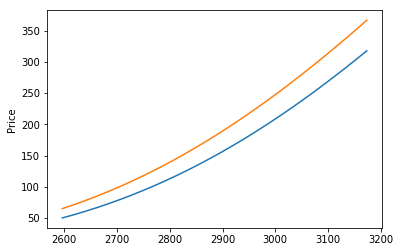

In [981]:
plt.plot(So,priceBS,So,EuroBS[0])
plt.ylabel("Price")

Text(0, 0.5, 'Delta')

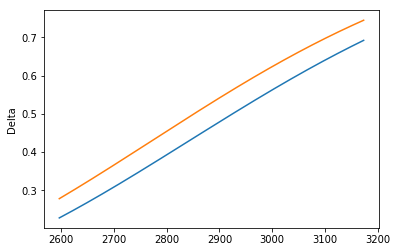

In [982]:
plt.plot(So,deltaBS,So,EuroBS[1])
plt.ylabel("Delta")

Text(0, 0.5, 'Gamma')

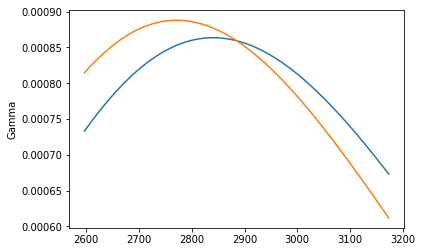

In [983]:
plt.plot(So,gammaBS,So,EuroBS[2])
plt.ylabel("Gamma")

In [1057]:
# centered delta calc for MC
def delta_MC(epsilon,So, monteCarlo):
    delta = np.zeros_like(So)
    for i in range(len(So)):
        plus = np.squeeze(monteCarlo(So[i]*(1+epsilon)))
        minus = np.squeeze(monteCarlo(So[i]*(1-epsilon)))
        delta[i] = (plus - minus) / (2*So[i]*epsilon)
    return delta

# centered gamma calc for MC
def gamma_MC(epsilon,So, monteCarlo):
    gamma = np.zeros_like(So)
    for i in range(len(So)):
        plus = np.squeeze(monteCarlo(So[i]*(1+epsilon)))
        minus = np.squeeze(monteCarlo(So[i]*(1-epsilon)))
        flat = np.squeeze(monteCarlo(So[i]))
        gamma[i] = (plus + minus - 2*flat) / ((epsilon*So[i])**2)
    return gamma



In [1058]:
monteCarlo = lambda x: MC([1000],x,2885,.023,.0198,.157,1,'Asymptotic Call')[0]

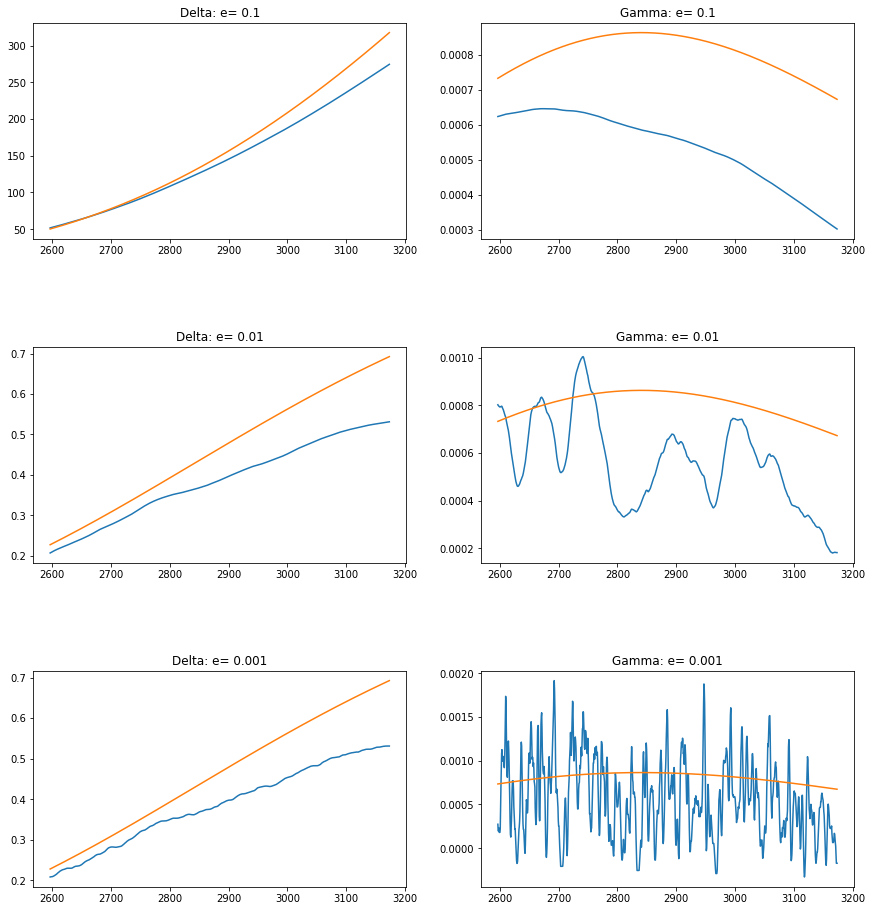

In [986]:
#plt.figure(figsize = (7,7))

fig, axs = plt.subplots(3,2)
axs[0,0].plot(So,priceMC,So,priceBS)
axs[0,0].set_title('Delta: e= 0.1')
axs[0,1].plot(So,gammaMC_1,So,gammaBS)
axs[0,1].set_title('Gamma: e= 0.1')

axs[1,0].plot(So,deltaMC_01,So,deltaBS)
axs[1,0].set_title('Delta: e= 0.01')
axs[1,1].plot(So,gammaMC_01,So,gammaBS)
axs[1,1].set_title('Gamma: e= 0.01')

axs[2,0].plot(So,deltaMC_001,So,deltaBS)
axs[2,0].set_title('Delta: e= 0.001')
axs[2,1].plot(So,gammaMC_001,So,gammaBS)
axs[2,1].set_title('Gamma: e= 0.001')


fig.subplots_adjust(left=.1,right= 2,bottom = 1,top = 4,hspace=0.5)
plt.show()



In [987]:
MC([1000],2885,2885,.023,.0198,.157,1,'Asymptotic Call')[0]

[139.47770585072786]

In [988]:
deltaMC_1 = delta_MC(.1,So,monteCarlo)
deltaMC_01 = delta_MC(.01,So,monteCarlo)
deltaMC_001 = delta_MC(.001,So,monteCarlo)
gammaMC_1 = gamma_MC(.1,So,monteCarlo)
gammaMC_01 = gamma_MC(.01,So,monteCarlo)
gammaMC_001 = gamma_MC(.001,So,monteCarlo)

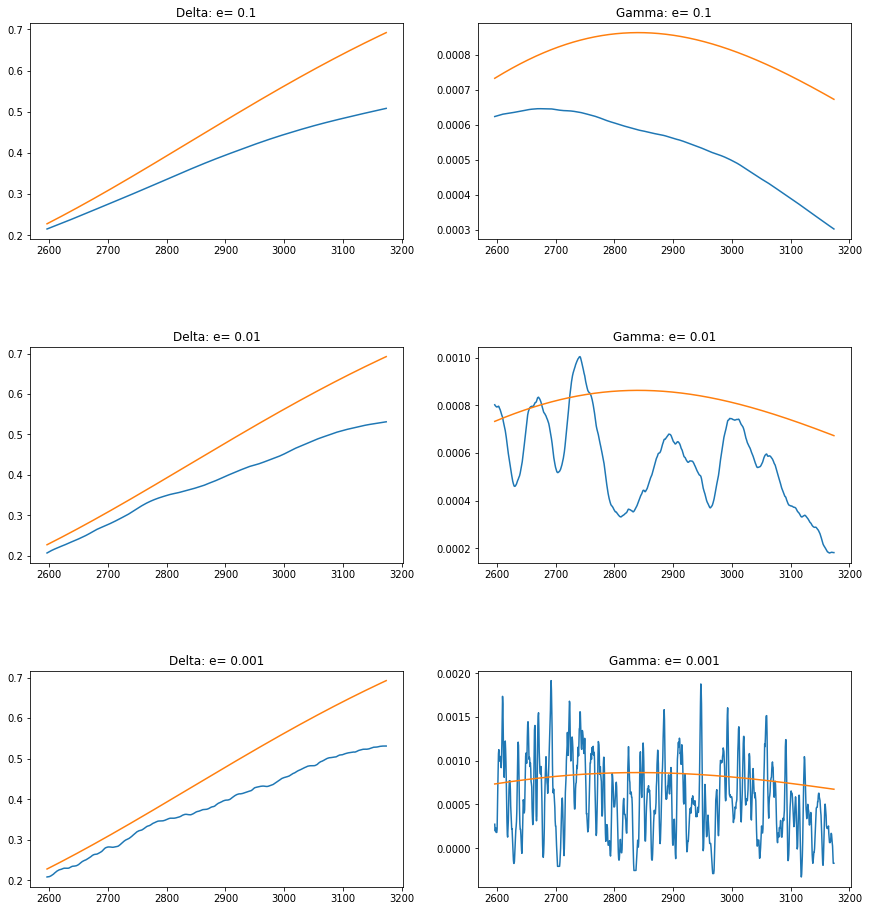

In [989]:
#plt.figure(figsize = (7,7))

fig, axs = plt.subplots(3,2)
axs[0,0].plot(So,deltaMC_1,So,deltaBS)
axs[0,0].set_title('Delta: e= 0.1')
axs[0,1].plot(So,gammaMC_1,So,gammaBS)
axs[0,1].set_title('Gamma: e= 0.1')

axs[1,0].plot(So,deltaMC_01,So,deltaBS)
axs[1,0].set_title('Delta: e= 0.01')
axs[1,1].plot(So,gammaMC_01,So,gammaBS)
axs[1,1].set_title('Gamma: e= 0.01')

axs[2,0].plot(So,deltaMC_001,So,deltaBS)
axs[2,0].set_title('Delta: e= 0.001')
axs[2,1].plot(So,gammaMC_001,So,gammaBS)
axs[2,1].set_title('Gamma: e= 0.001')


fig.subplots_adjust(left=.1,right= 2,bottom = 1,top = 4,hspace=0.5)
plt.show()


#### We see that the MC delta using finite difference method seems to tail off deep in the money, producing lower delta numbers as compared to the BS closed-form values.  The MC gamma approximation behaves well for epsilon values of 0.1, less so for 0.01, and is extremely noisy for epsilon = 0.001.  


In [990]:
monteCarlo = lambda x: MC([1000],x,2885,.023,.0198,.157,1,'Asymptotic Call')[0]

In [991]:
MC([1000],2885,2885,.023,.0198,.157,1,'Control Variate2',.99305081)[0]

[147.11988990195889]

### Likelihood Ratio Sensitivities for py, v, delts, gamma and their standard errors

In [1439]:
# Monte Carlo Simulator
def MC_greeks(batches,St,K,r,q,sigma,T,flavor='Call',alpha=0,style='euro',seed=2,t=0):
    dt = T-t
    d2s = []
    rho = []
    for i in range(len(So)):
        
    for n in batches:
        np.random.seed(seed)
        draws = np.random.normal(size=n)
        stoch = sigma*np.sqrt(dt)*draws
        
        mu = (r - q - sigma*sigma*0.5*dt)
        ST = (St*np.exp(mu + stoch))
        
        
        
        
        if flavor == 'Put':
            payoff = np.maximum((K - ST),0)
        elif flavor == 'Call':
            payoff = np.maximum((ST - K),0)
        elif flavor == 'Asymptotic Call':
            payoff = np.maximum((K - K*K/ST),0)
        elif flavor == 'Control Variate':
            payoff = (K/ST - alpha)* np.maximum((ST - K),0)
        elif flavor == 'Control Variate2':
            payoff = (K/ST - alpha)* np.maximum((ST - K),0) + St*np.exp(-q*dt)*norm.cdf(d1) - K*np.exp(-r*dt)*norm.cdf(d2)
        elif flavor == 'Power Call':
            payoff = np.maximum((ST*ST - K),0)
       
        
    
        #payout2.append(np.maximum((K - K*K/ST[n]),0))
        #d2s.append(((np.log(ST/K) - (r-q+sigma*sigma*0.5)*dt) / (sigma*np.sqrt(dt))))
        #rho.append(np.mean((-np.sqrt(dt) / sigma) * (np.exp(-r*dt) * d2s*payoff)))
       
        #payout2.append = np.mean(payout2)
        #payoff.append(np.mean(PVs))
        #stdev.append(np.std(PVs)/np.sqrt(n))
        #print(ST)
    return payoff, rho

In [1435]:
def LR_pY(So,monteCarlo):
    #ST = np.zeros_like(So)
    #d2 = np.zeros_like(So)
    #payout = np.zeros_like(So)
    #rho = np.zeros_like(So)
    #ST = []
    rho = []
    for i in range(len(So)):
        ST = np.squeeze(monteCarlo(So[i]))
        #ST = monteCarlo(So[i])
       
        rho[i] = ST[i]
        #payout[i] = np.maximum((K - K*K/So[i]),0)
        #d2[i] = ((np.log(So[i]/K) - (r-y+sigma*sigma*0.5)*T) / (sigma*np.sqrt(T)))
        #rho[i] = (-np.sqrt(T) / sigma) * (np.exp(-r*T)/ len(So))**d2[i]*(payout[i])
    return ST

def gamma_MC(epsilon,So, monteCarlo):
    gamma = np.zeros_like(So)
    for i in range(len(So)):
        plus = np.squeeze(monteCarlo(So[i]*(1+epsilon)))
        minus = np.squeeze(monteCarlo(So[i]*(1-epsilon)))
        flat = np.squeeze(monteCarlo(So[i]))
        gamma[i] = (plus + minus - 2*flat) / ((epsilon*So[i])**2)
    return gamma

In [1437]:
LRmonteCarlo = lambda x: MC_greeks([1000],x,2885,.023,.0198,.157,1,'Asymptotic Call')[1]

In [1438]:
rhoYMC = LR_pY(So,LRmonteCarlo)
rhoYMC

IndexError: index 0 is out of bounds for axis 0 with size 0

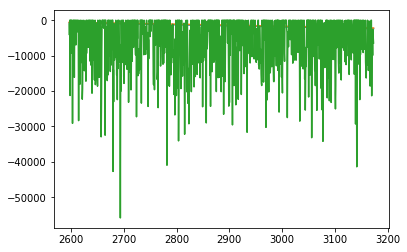

In [1419]:
plt.plot(So,EuroBS[5],So,AsymBS[5], So, rhoYMC)

### Control Variate Method

In [821]:
CVmonteCarlo = lambda x: MC([1000],x,2885,.023,.0198,.157,1,'Control Variate2',.99305081)[0]

CVdeltaMC_1 = delta_MC(.1,So,CVmonteCarlo)
CVdeltaMC_01 = delta_MC(.01,So,CVmonteCarlo)
CVdeltaMC_001 = delta_MC(.001,So,CVmonteCarlo)
CVgammaMC_1 = gamma_MC(.1,So,CVmonteCarlo)
CVgammaMC_01 = gamma_MC(.01,So,CVmonteCarlo)
CVgammaMC_001 = gamma_MC(.001,So,CVmonteCarlo)


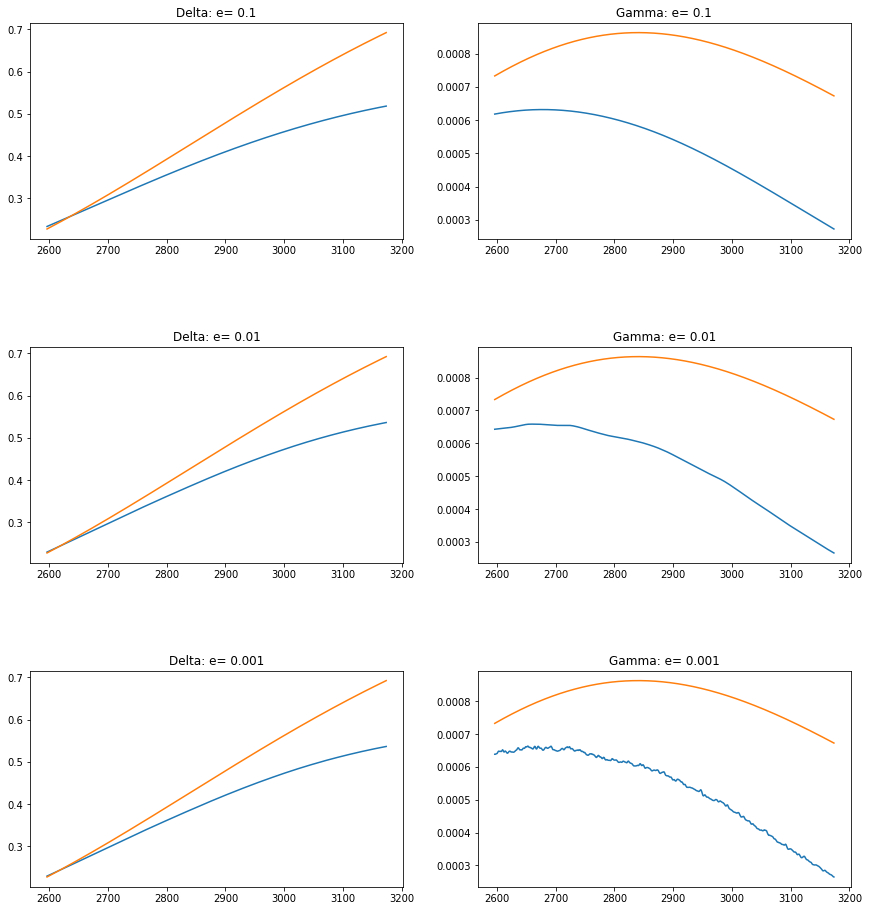

In [822]:
fig, axs = plt.subplots(3,2)
axs[0,0].plot(So,CVdeltaMC_1,So,deltaBS)
axs[0,0].set_title('Delta: e= 0.1')
axs[0,1].plot(So,CVgammaMC_1,So,gammaBS)
axs[0,1].set_title('Gamma: e= 0.1')

axs[1,0].plot(So,CVdeltaMC_01,So,deltaBS)
axs[1,0].set_title('Delta: e= 0.01')
axs[1,1].plot(So,CVgammaMC_01,So,gammaBS)
axs[1,1].set_title('Gamma: e= 0.01')

axs[2,0].plot(So,CVdeltaMC_001,So,deltaBS)
axs[2,0].set_title('Delta: e= 0.001')
axs[2,1].plot(So,CVgammaMC_001,So,gammaBS)
axs[2,1].set_title('Gamma: e= 0.001')


fig.subplots_adjust(left=.1,right= 2,bottom = 1,top = 4,hspace=0.5)
plt.show()